# 3. 분류
## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

배열 탐색

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

이미지가 28x28 pixel이고 특성은 0~255의 픽셀 강도를 나타냄  

**이미지 확인**  
특성 벡터를 추출하여 28x28 배열로 크기를 바꾸고, 맷플롯립의 imshow()로 그려봄

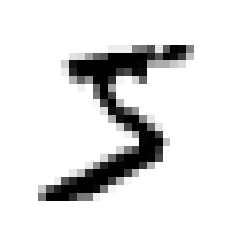

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

레이블이 문자로 정의되어있기 때문에 target(y)을 정수로 변환

In [7]:
import pandas as pd
import numpy as np

In [8]:
y = y.astype(np.uint8)

train, test set split  
- mnist 자료는 훈련 세트가 앞 60,000, 테스트 세트가 뒤 60,000로 나뉘어 있음

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련
문제를 단순화하여 5인 것, 5가 아닌 것으로만 분류하는 **이진 분류기**를 만들어보자.

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

`SGDClassifier`를 사용해 **확률적 경사 하강법** 분류기로 시작  
SGD는 훈련 샘플을 한 번에 하나씩 독립적으로 처리함(온라인 학습에 잘 쓰임)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) #SGD는 훈련하는데 무작위성을 사용하여 random_state 지정
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

### 3.3 성능 측정

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 이미지를 5가 아니라고 출력하는 더미 분류기와 비교

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

**정확도(accuracy)는 특히 불균형한 데이터셋을 다룰 때 분류기의 성능 측정 지표로 선호하지 않음**  
위 더미 측정기가 정확도 90대가 나왔음.. 이미지의 10% 정도만 5이기 때문

### 3.3.2 오차 행렬
<img src='https://blog.kakaocdn.net/dn/S1z2M/btqvWpQKfvo/O2gB015AN6589ZBDuTBv71/img.png' width=50%>

먼저 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함.(test set는 분류기 작업이 끝난 후 마지막에 사용)  
`cross_val_predict()`: 평가 점수를 반환하지 않은 **깨끗한 예측**을 얻을 수 있음

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`confusion_matrix(target class, predict class)` 오차 행렬 만들기

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

완벽한 분류기라면 diag matrix가 되어야 할 것!

In [18]:
#완벽한 분류기
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

**`정밀도(precison)`**
- TP/(TP+FP)
- 양성 예측의 정확도
- 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율  
*TP: 진짜 양성, FP: 거짓 양성*

**`재현율(recall)`**, 민감도, 진짜 양성 비율(TPR)
- TP/(TP+FN)
- 분류기가 정확하게 감지한 양성 샘플의 비율
- 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율

### 3.3.3 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**F1점수**: 정밀도와 재현율의 조화 평균  
`f1_score()` 호출로 사용

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

상황에 따라 정밀도와 재현율을 추구하는 것이 달라진다.  
아동을 위한 동영상 필터링의 경우 좋은 영상이 걸러지더라도 나쁜 영상이 나오지 않는 것이 중요하므로, <u>안정적인 높은 정밀도를 선호</u>할 것이다.  
반면, 좀도둑을 잡는 분류기를 훈련시킨다면 좀도둑을 잡는 것이 중요하므로 <u>재현율을 선호</u>할 것이다.

### 3.3.4 정밀도/재현율 트레이드오프

- 정밀도나 재현율은 한 쪽을 올리면 한 쪽이 낮아짐
- 사이킷런에서는 임곗값을 직접 지정할 수는 없지만 예측에 사용된 점수를 확인할 수 있음
- `decision_function()`으로 각 샘플의 점수를 확인하고, 원하는 임곗값을 정해 예측을 만들 수 있음  

*cf. predict() 매서드도 decision_funtion()을 사용해 0보다 큰 경우를 양성으로 예측*

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

임곗값 높이기

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임곗값을 높이면 재현율이 줄어든다는 것을 확인

적절한 임곗값을 찾기 위해서는 cross_val_predict()를 사용하여 <u>예측 결과가 아니라 결정 점수를 반환</u>받도록 지정해야 함  
`method='decision_function'`

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

`precision_recall_curve(분류기, 결정 점수)`로 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

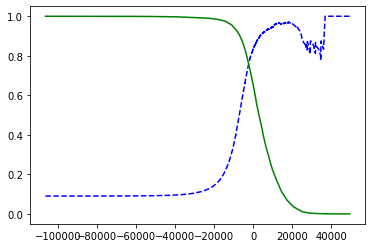

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

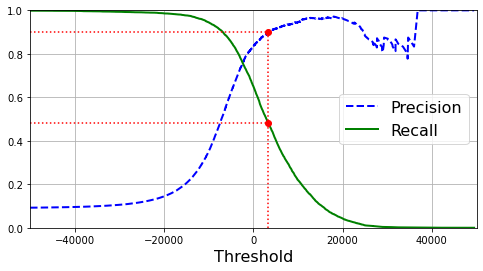

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

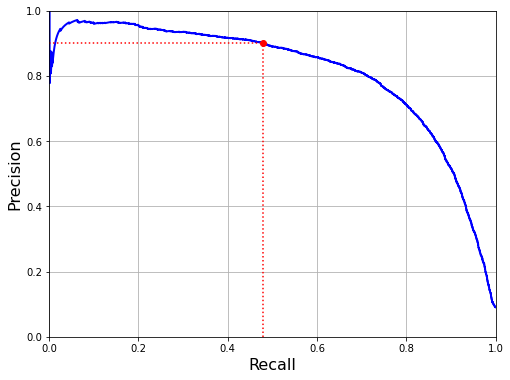

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

좋은 젇밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것

최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음  
`np.argmax()`는 최댓값의 첫 번째 인덱스를 반환

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

훈련 세트에 대한 예측을 만들기 위해서는 분류기의 predict() 대신 다음 코드를 실행

In [32]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

### 3.3.5 ROC 곡선

- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR) 곡선
- 민감도(재현율)에 대한 1-특이도(TNR, 진짜 음성 비율) 그래프
- `roc_curve()`를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야 함

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

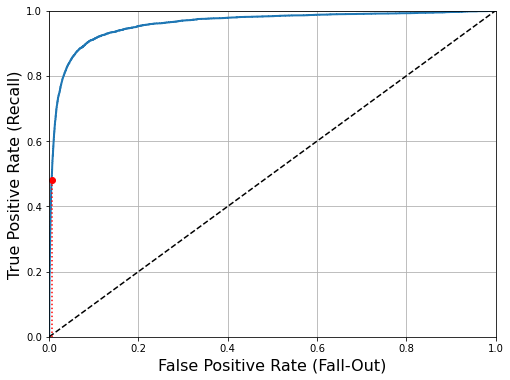

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

재현율(TPR)이 높을수록 거짓 양성(FPR)이 높은 트레이드오프  
점선은 완전 랜덤 분류기의 ROC 곡선을 뜻하며, 좋은 분류기는 점선에서 최대한 멀리 떨어져있어야 함

**AUC**(곡선 아래의 면적)을 측정하여 분류기들을 비교할 수 있음  
완벽한 분류기는 1, 완전 랜덤 분류기는 0.5  
`roc_auc_score`로 auc를 계산

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**? ROC 곡선과 PR(정밀도/재현율) 곡선 중 뭘 사용해야 할까**  
- 양성 class가 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 땐 PR 곡선을 사용
- 그렇지 않으면 ROC 곡선 사용
- PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여줌

RandomForestClassifier를 사용한 예

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')

roc_curve()는 레이블과 점수를 기대하지만, 점수 대신 클래스 확률을 전달할 수 있음  
양성 클래스 확률을 점수로 사용

In [39]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스를 저수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

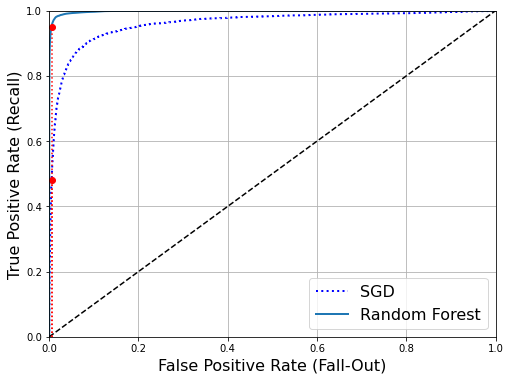

In [40]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류
일부 알고리즘은 여러 클래스를 처리할 수 있지만 다른 알고리즘은 이진 처리만 가능  
그러나 이진분류기를 여러 개 사용하여 다중 클래스를 분류하는 기법도 많음

**OvR(One versus the rest)**  
- N개의 클래스가 존재한다면, N개의 분류 함수가 필요
- 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
- 대부분의 이진 분류 알고리즘은 OvR을 선호
- 하나의 class와 그 외의 나머지 모든 class를 비교하는 classifier를 각각의 class마다 학습시키고, 생성된 모든 classifier 중 가장 큰 예측값을 가지는 class를 최종 예측값으로 선택

**OvO(One versus one)**
- N개의 클래스가 존재한다면 분류기는 N(N-1)/2개가 필요
- 숫자의 조합마다 이진 분류기를 훈련
- 가장 많이 양성으로 분류된 클래스를 선택
- 장점으로는 두 클래스에 해당하는 샘플만 필요
-  하나의 class와 또다른 하나의 class를 비교하는 classifier를 각각의 class마다 학습시키고, classifier들의 예측값들을 비교하여 가장 많이 예측된 class를 최종 예측값으로 선택하는 방법

사이킷런에서는 알고리즘에 따라 자동으로 OvR, OvO를 실행

In [42]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

`decision_function` 매서드를 호출하면 샘플당 10개의 점수를 반환하고, 점수는 클래스마다 하나씩임

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
np.argmax(some_digit_scores)

5

분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 지정

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[5]

5

사이킷런에서 OvO, OvR을 사용하도록 강제하려면 `OneVsOneClassifier`, `OneVsRestClassifier`를 사용

In [47]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

SGDClassifier를 훈련시키기

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

분류기 평가하기

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [53]:
# 입력 스케일을 조정하여 정확도 높이기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
모델의 성능을 향상시킬 방법 중 하나는 만들어진 에러의 종류를 분석하는 것

- 오차 행렬

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

맷플롯립의 `matshow()`로 시각화하면 보기 편리함

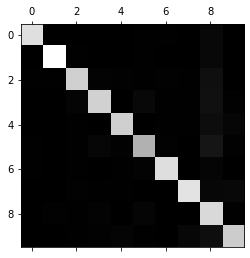

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

숫자 5가 다른 숫자보다 어두움 > 이미지가 적거나 분류기가 잘 분류하지 못한다는 뜻  

- 에러에 초점을 맞추자  
오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눠 에러 비율 비교

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

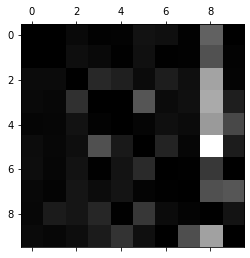

In [57]:
#주대각선만 0으로 채우기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행: 실제 클래스
- 열: 예측 클래스

8행이 밝기 때문에 잘못 분류된 것 같지만 클래스 8의 행을 보면 적절히 분류되었음  
**오차 행렬은 반드시 대칭인 것이 아님**. 오차 행렬을 분석하면 분류기의 성능 향상 방안의 통찰을 얻을 수 있음

## 3.6 다중 레이블 분류
- 여러 개의 이진 꼬리표를 출력하는 분류 시스템
- ex) 같은 사진에 여러 사람이 등장
- 결정 트리, 랜덤 포레스트, OvR clf에서도 다중 레이블 분류를 지원

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) 
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel) #다중 타깃 배열을 사용하여 훈련

KNeighborsClassifier()

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [61]:
#모든 레이블에 대한 F1 점수의 평균 계산

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

해당 코드는 모든 레이블의 가중치가 같다고 가정  
샘플들의 비중이 다르다면 레이블에 클래스의 `지지도(타깃 레이블에 속한 샘플 수)`를 가중치로 줄 수 있음! `average='weighted'`

## 3.7 다중 출력 분류
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화(값을 두 개 이상 가질 수 있음)

MNIST 이미지에서 추출한 train/test set에 `randint()`로 픽셀 강도에 잡음을 추가

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

깨끗한 이미지로 만들기

In [66]:
some_index = 0

knn_clf.fit(X_train.mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

AttributeError: 'numpy.ndarray' object has no attribute 'mod'